In [ ]:
from torchvision import transforms,datasets
from   PIL import Image
import torch
import torch.nn as nn
import os
import numpy as np
import cv2

In [ ]:
path_1 = 'E:\Download\high\\'
path_2 = 'E:\Download\low2\\'
def data_proc(path_1,path_2):
    path_list = []
    train_data = []
    fil_1 = os.listdir(path_1)
    fil_2 = os.listdir(path_2)
    for path  in fil_1:
        path_list.append((path_1+path,path_2+path))
    np.random.shuffle(path_list)
    for index,(Pdata,Plabel) in enumerate(path_list):
        data = cv2.imread(Pdata)
        label = cv2.imread(Plabel)
        print(data.shape,label.shape)
        break
        for i in range(10):
            for j in range(15):
                datas = data[i*40:i*(40+1),j*40:j*(40+1)]
                labels = label[i*40:i*(40+1),j*40:j*(40+1)]
                train_data.append((datas,labels))
    np.random.shuffle(train_data)
    data_txt = open('image_enhance_data.txt','w+')
    data_txt.write(train_data)
    print(train_data[1])
data_proc(path_1,path_2)

In [ ]:
path_1 = 'E:\Download\high\our485\high\\'
path_2 = 'E:\Download\high\our485\low\\'
savepath = 'E:\Download\ImageCrop\\'
def Crop_image(path_1,path_2,savepath):
    image_1 = os.listdir(path_1)
    image_2 = os.listdir(path_2)
    k = 0
    for image_name in image_1:
        
        image_p1 = path_1 + image_name
        image_p2 = path_2 + image_name
        img1 = cv2.imread(image_p1)
        img2 = cv2.imread(image_p2)
        #print(img1.shape,img2.shape)
        for i in range(10):
            for j in range(15):
                k += 1
                img_1 = img1[i*40:(i+1)*40,j*40:(j+1)*40,:]
                img_2 = img2[i*40:(i+1)*40,j*40:(j+1)*40,:]
                #print(img_1.shape)
                #print(savepath+'high\\'+str(i)+str(j)+'.jpg')
                cv2.imwrite(savepath+'high\\'+str(k)+'.jpg',img_1)
                cv2.imwrite(savepath+'low\\'+str(k)+'.jpg',img_2)
        print('图像{}切割保存成功'.format(image_name))
Crop_image(path_1,path_2,savepath)

In [ ]:
print(len(os.listdir('E:\Download\ImageCrop\high')))

In [ ]:
print(len(os.listdir('E:\Download\ImageCrop\low')))

In [ ]:
from torch.utils.data import Dataset,DataLoader
import pandas as pd
def path_list_txt(root):
    path_list = []
    clas = os.listdir(root)
    name_1 = os.listdir(root +'\\'+ clas[0])
    name_2 = os.listdir(root + '\\' + clas[1])  
    path = list(zip(name_1,name_2))
    np.random.shuffle(path)
    sub_root_1 = root + '\\' + clas[0]
    sub_root_2 = root + '\\' + clas[1]
    f =  open('data.txt','w')
    for index,(img_1,img_2) in enumerate(path):
        #print(img_1,img_2)
        #break
        #path_list.append([sub_root_1+'\\'+img_1,sub_root_2 + '\\'+img_2])
        f.writelines([sub_root_1+'\\'+img_1+'\t'+sub_root_2 + '\\'+img_2+'\n'])
    #print(path)
    f.close()
    print('写入成功')
root = 'E:\Download\ImageCrop'
path_list_txt(root)

In [ ]:
with open('data.txt','r') as f:
    for i in f:
        high_path,low_path = i.split('\t')
        print(high_path,low_path)
        break

In [ ]:
from torchvision import transforms,datasets
from   PIL import Image
import torch
import torch.nn as nn
import os
import numpy as np
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torch.nn.functional as F
class MyDatasets(Dataset):
    def __init__(self,text,transform=None):
        self.imgs = []
        self.labels = []
        file = open(text,'r')
        for i in file:
            img,label = i.split('\t')
            self.imgs.append(img)
            self.labels.append(label)
        self.transform = transform
        
    def __getitem__(self,index):
        image = cv2.imread(self.imgs[index])
        Label = cv2.imread(self.imgs[index])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
        Label = cv2.cvtColor(Label,cv2.COLOR_BGR2HSV)
        H_H,H_S,H_I = cv2.split(image)
        L_H,L_S,L_I = cv2.split(Label)
        img = H_I
        label = L_I
        if self.transform is not None:
            img = self.transform(img)
            label = self.transform(label)
        else:
            img = torch.FloatTensor(img.reshape(1,40,40))
            label = torch.FloatTensor(label.reshape(1,40,40))
        return img,label
    
    def __len__(self):
        return len(self.imgs)

In [ ]:
text = 'data.txt'
batch_size = 64
MyDataset = MyDatasets(text)
train_data = DataLoader(MyDataset,batch_size=batch_size,shuffle = True,drop_last = True)

In [ ]:
for i,(data,label) in enumerate(train_data):
    print(i,len(data),label.shape)
    break
print(len(train_data))    

In [ ]:
from torchvision import transforms,datasets
from   PIL import Image
import torch
import torch.nn as nn
import os
import numpy as np
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
class ResBlock(nn.Module):
    def __init__(self,in_channel,out_channel,kernel_size,stride,padding):
        super(ResBlock,self).__init__()
        
        self.cov1 = nn.Conv2d(in_channel,out_channel,kernel_size ,stride,padding)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.cov2 = nn.Conv2d(out_channel,out_channel,kernel_size ,stride,padding)
        self.bn2 = nn.BatchNorm2d(out_channel)
        # 恒等映射保证和输出维度一致
        if in_channel != out_channel:
            self.identity = nn.Sequential(
             nn.Conv2d(in_channel,out_channel,kernel_size ,stride,padding),
             nn.BatchNorm2d(out_channel)
            )
        else:
            self.identity = nn.Sequential()
        
    def forward(self,x):
        out = F.relu(self.cov1(x))
        out = self.bn1(out)
        out = F.relu(self.cov2(out))
        out = self.bn2(out)
        out = self.identity(x) + out
        out = F.relu(out)
        return out
        

In [ ]:
class ResNet(nn.Module):
    
    def __init__(self):
        super(ResNet,self).__init__()
        
        self.module = nn.Sequential(
            nn.Conv2d(1,64,3,stride = 1,padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            ResBlock(64,64,3,1,1),
            ResBlock(64,64,3,1,1),
            ResBlock(64,64,3,1,1),
            nn.Conv2d(64,1,3,1,1),
            nn.ReLU()
        )
    
    def forward(self,x):
        return self.module(x)

In [ ]:
a = torch.randn(1,1,64,64)
Net = ResNet()
print(Net(a).shape)

In [ ]:
epochs = 50
device = torch.device('cuda:0')
CovResNet = ResNet().to(device)
loss_fun = nn.MSELoss().to(device)
optimizer = optim.Adam(CovResNet.parameters())

In [ ]:
loss_list = []
def Running():
    for epoch in range(epochs):
        lossvalue = 0
        for index,(datas,labels) in enumerate(train_data):
            data = datas.cuda()
            #print(data)
            label = labels.cuda()
            logits = CovResNet(data)
            loss = loss_fun(logits,label)
            lossvalue+=loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print('epoch:{}\tbatch:{}\tave_loss:{}'.format(epoch+1,index+1,loss.item()/len(datas)))
        loss_list.append(lossvalue/len(train_data))
        print('epoch:{}\tave_loss:{}'.format(epoch+1,lossvalue/len(train_data)))

In [10]:
Running()

epoch:48	batch:18	ave_loss:0.011208314448595047
epoch:48	batch:19	ave_loss:0.039829716086387634
epoch:48	batch:20	ave_loss:0.01996760442852974
epoch:48	batch:21	ave_loss:0.013347573578357697
epoch:48	batch:22	ave_loss:0.012826496735215187
epoch:48	batch:23	ave_loss:0.010825200006365776
epoch:48	batch:24	ave_loss:0.4284706115722656
epoch:48	batch:25	ave_loss:0.06516166031360626
epoch:48	batch:26	ave_loss:0.37161749601364136
epoch:48	batch:27	ave_loss:0.44739747047424316
epoch:48	batch:28	ave_loss:0.23767872154712677
epoch:48	batch:29	ave_loss:0.015685373917222023
epoch:48	batch:30	ave_loss:0.021593190729618073
epoch:48	batch:31	ave_loss:0.03193051367998123
epoch:48	batch:32	ave_loss:0.14454081654548645
epoch:48	batch:33	ave_loss:0.06010330095887184
epoch:48	batch:34	ave_loss:0.1417628824710846
epoch:48	batch:35	ave_loss:0.07004079222679138
epoch:48	batch:36	ave_loss:0.040285926312208176
epoch:48	batch:37	ave_loss:0.07422182708978653
epoch:48	batch:38	ave_loss:0.034280456602573395
epoch:

In [11]:
path = 'DRCNN_50batch.pr'
torch.save(CovResNet.state_dict(),path)

[1086.6628018858898, 56.83836147461459, 47.44259764209555, 40.56108697309747, 36.82863100729469, 32.98250605375924, 34.21291478162745, 34.18429624189382, 31.537439638075924, 33.87016597942447, 35.52884491893799, 29.579146594852592, 29.836887391890144, 31.88925070507113, 32.09438971649572, 31.11770873218393, 27.30985287155075, 31.21287086796903, 27.614582205714576, 27.343293355785814, 26.111647601162236, 25.03675244660789, 23.824580207530705, 18.945830785749713, 20.685900006815473, 15.569231670143052, 15.654138424883126, 14.719308709762322, 13.477522963443239, 12.314921490561748, 11.471678123883363, 10.735694314403274, 11.27228178482194, 10.463430942581008, 10.318464678541195, 9.557185420869864, 11.254405587122646, 9.339424914727346, 8.052757779570547, 8.554200561203375, 9.305227675008325, 9.275470768305912, 10.07181186003119, 8.33364637324588, 8.762239614172332, 8.248316347090023, 8.252056746198823, 6.725729743147588, 7.9071955220196415, 6.252406079885188]


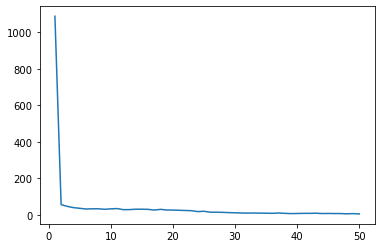

In [16]:
print(loss_list)
import matplotlib.pyplot as plt
import numpy as np
epoch_s = [i+1 for i in range(len(loss_list))]
plt.plot(epoch_s,loss_list)
plt.show()


In [26]:
import pandas as pd
data = pd.Series(loss_list)
data.to_csv('epochsloss.csv',index = False,header = False)

In [13]:
net = ResNet().cuda()
net.load_state_dict(torch.load('Parameter.txt'))
#a = torch.randn(1,1,64,64).cuda()

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
for index ,(datas,labels) in enumerate(train_data):
    if index == 3:
        print(datas,labels)
        break

In [ ]:
image = cv2.imread('E:\Download\ImageCrop\high\\1.jpg')
Label = cv2.imread('E:\Download\ImageCrop\low\\1.jpg')
#print(image,Label)
image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
Label = cv2.cvtColor(Label,cv2.COLOR_BGR2HSV)
H_H,H_S,H_I = cv2.split(image)
L_H,L_S,L_I = cv2.split(Label)
img = H_I
label = L_I
transform = transforms.ToTensor()
print(transform(img))
print(transform(label))

In [15]:
import cv2
import torch
path_1 = 'E:\Download\ImageCrop\low\\1.jpg'
path_2 = 'E:\Download\ImageCrop\high\\1.jpg'
low_image = cv2.imread(path_1)
low_image = cv2.cvtColor(low_image,cv2.COLOR_BGR2HSV)
H,S,I = cv2.split(low_image) 
print(I.size)
image = torch.FloatTensor(I).reshape(1,1,40,40).cuda()
print(image)
#print(image)
a = net(image)
#print(a)
b = a.reshape(40,40)
b  = b.cpu()
#print(b)
I = b.detach().numpy()
I = np.array(I,dtype = 'uint8')
re = cv2.merge([H,S,I])
re_img = cv2.cvtColor(re,cv2.COLOR_HSV2BGR)
low = cv2.imread(path_1)
high = cv2.imread(path_2)
#cv2.imwrite('E:\Download\test\low\\1.jpg',low)
#print('写入成功')
#cv2.imwrite('E:\Download\test\reconstruction\\1.jpg',re_img)
#print('写入成功')
cv2.namedWindow('low_image')
cv2.namedWindow('high_image')
cv2.namedWindow('re_img')
cv2.imshow('re_img',re_img)
cv2.imshow('low_image',low)
cv2.imshow('high_image',high)
cv2.waitKey(0)
cv2.destroyAllWindows()

1600
tensor([[[[23., 24., 25.,  ..., 15., 13., 16.],
          [27., 26., 27.,  ..., 14., 14., 16.],
          [28., 25., 27.,  ..., 14., 15., 15.],
          ...,
          [18., 20., 21.,  ..., 13., 12., 11.],
          [18., 19., 20.,  ..., 13., 11., 10.],
          [17., 19., 19.,  ..., 18., 17., 16.]]]], device='cuda:0')
